<a href="https://colab.research.google.com/github/ellenne/AdvancedComputerVision/blob/main/CNN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# basic libraries
import torch
import torchvision

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

In [4]:
## Define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

# choose the training and test datasets
train_data = FashionMNIST(root='./data', train=True,
                          download=True, transform=data_transform)

test_data = FashionMNIST(root='./data', train=False,
                         download=True, transform=data_transform)

# print some stats about training and test data
print('Train data, number of images:', len(train_data))
print('Test data, number of images:', len(test_data))

Train data, number of images: 60000
Test data, number of images: 10000


In [5]:
# prepare data loaders, set the batch_size
batch_size = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

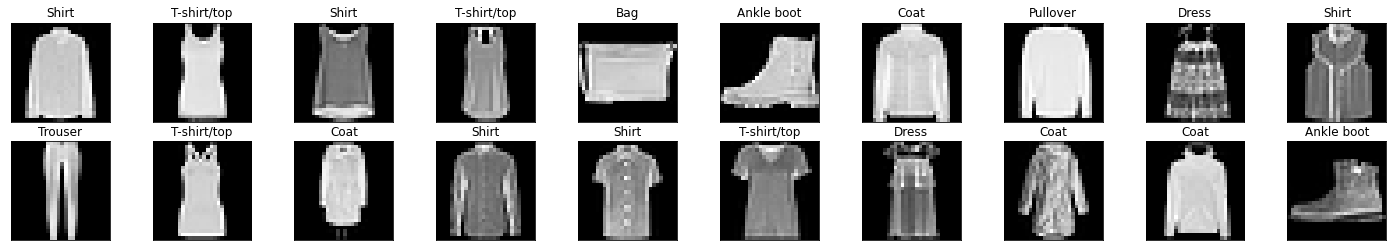

In [6]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
  ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title(classes[labels[idx]])

In [32]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()

    # Images in the MNIST database are 28x28 ; W = 28
    # We want to use a 3x3 kernel ; F=3
    # We want to use strive of 1  ; S=1
    # (W-F)/S + 1 = (28 - 3)/1 + 1 = 25 +1 = 26
    # We have 10 classes
    # Images are gray scale (k=1)
    # Output tensor will be (10, 26, 26)
    self.conv1 = nn.Conv2d(1, 10, 3)
    self.pool = nn.MaxPool2d(2, 2)

    # Note that we specifies 1 above because we have dealing with grey images
    # 10 are the classes and 3 is the kernel dimension 
    # after I placed a pool layer of dimension 2x2 with strive 1 
    # therefore the dimension of the matrix will be half, same width

    # (10, 13, 13)
    # here I have to apply a second convolution layer
    # W = 13; F = 3 (kernel 3x3); S = 1
    # (W-F)/S + 1 = (13-3)/1 + 1 = 11
    # (20, 11, 11)
    self.conv2 = nn.Conv2d(10, 20, 3)

    # we do not have to forget that we have a pool layer 
    # after conv2 so the tensor from (20, 11, 11)
    # becomes (20, 5, 5) (round down 11/2=5.5 --> 5)

    # now we put a flatten layer 
    self.fc1 = nn.Linear(20*5*5, 10)

    # drop out
    self.dropout = nn.Dropout(p=0.2, inplace=True)

  def forward(self, x):  
    x = self.pool(F.relu(self.conv1(x)))
    # here we are inserting the pooling layer after conv2 
    # above in the init we included the caluclation but 
    # we are defining it here
    x = self.pool(F.relu(self.conv2(x)))

    # flatten layer
    x = x.view(x.size(0), -1)

    x = self.fc1(x)
    x = self.dropout(x)
    x = F.log_softmax(x, dim=1)

    return x

# instantiate and print the network
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=True)
)


In [20]:
import torch.optim as optim

criterion = nn.NLLLoss()

# I am using Adam optimizer with low Learning Rate
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [33]:
correct = 0
total = 0

# Iterate through test dataset
for images, labels in test_loader:

  #forward pass to get outputs
  #the outputs are a series of class scores
  outputs = net(images)

  # get the predicted class from the maximum value in the output-list of scores
  _, predicted = torch.max(outputs.data, 1)

  # count up total number of correct labels
  # for which predicted and true labels are equal
  total += labels.size(0)
  correct += (predicted == labels).sum()

# calculate accuracy
# to convert `correct` from a tensor into a scalar, using .item()
accuracy = 100.0 * correct.item() / total

# print accuracy
print('Accuracy before training:',accuracy)

Accuracy before training: 10.59
